# Conway's Way of Life
Here's a fun way to simulate how a hypothetical colony of (micro?) organisms evolves with time. We have a matrix of given dimensions initialized to zero. Initially, some randomly chosen points are "**activated**", which means their value is set to 255 (highest pixel intensity). Starting from here, the matrix (called testbed this point forward) is updated with the following rules:

- Any active cell with fewer than two live neighbours dies, as if by underpopulation.
- Any active cell with two or three live neighbours lives on to the next generation.
- Any active cell with more than three live neighbours dies, as if by overpopulation.
- Any dead cell with exactly three live neighbours becomes an active cell, as if by reproduction.

The key point in implementing this algorithm is to determine how many neighbors for each node are active. In a rectangular matrix, every node has 8 neighbors forming a square boundary around it. The rules above apply to these 8 neighbors. 

## Approach
To find the state of each node, we consider a sliding windows of size $(3 \times 3)$ where the center of the window is the node under consideration and its fate is decided by all other nodes in the window. We will end up neglecting nodes on the boundary of the testbed if we perform this operation as is, so we first pad the entire testbed with zeros on all edges. Now starting from the top left, our window slides in a row-major form down to the bottom-right, using the following conditions. Below, consider 1 as a proxy for 255.

**(Case 1)** When the window has less than 3 active nodes.
<img src="files/sum_less_3.jpeg" style="width: 400px;">
The sum of all elements will be lesser than 3. Notice that irrespective of the central node being one or zero, we have to set it to zero.

**(Case 2)** When the window has 3 active nodes.
<img src="files/sum_3.jpeg" style="width: 400px;">
If the central node is initially 1, it survives to the next generation (rule 2) and if it was 0, then it becomes active (rule 4). Thus in both cases, we have to set it to 1.

**(Case 3)** When the window has 4 active nodes.
<img src="files/sum_4.jpeg" style="width: 400px;">
If the central node is initially 1, it survives to the next generation since it has 3 active neighbors (rule 2). If it was initially 0, we will leave it as is since we don't have an update rule specified for this case. So when the sum is 4, we need not take any action.

**(Case 4)** When the window has more than 4 active nodes.
<img src="files/sum_gr_4.jpeg" style="width: 400px;">
In the central node is initially 1, it should die (rule 3). If it was initially zero, we will leave it as 0. In both cases, the central node should become zero. 

## Caveats
In the code below, all of the conditions above have been scaled up to 255. Also, a parameter `density` has been added to testbed initialization. This parameter dictates what percentage of the testbed nodes have to be randomly activated. I was facing issues with embedding the resulting GIF in the notebook, so I have uploaded it as a separate file in the repository.

In [1]:
# Dependencies
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML       # NOT USED
plt.style.use('dark_background')

In [2]:
class ConwaysTestbed():
    
    def __init__(self):
        self.testbed = None
        self.rows = None
        self.cols = None
        self.scat = None
    
    def initialize_testbed(self, n_rows=50, n_cols=50, density=0.5):
        """
        Creates the testbed and randomly activates some nodes based
        on specified hyperparameters.
        """
        fig, ax = plt.subplots()
        ax.set_xlim((0, n_rows))
        ax.set_ylim((0, n_cols))
        scat = ax.scatter([], [], marker='.', s=10)
        
        self.testbed = np.zeros((n_rows+2, n_cols+2))
        self.rows = n_rows
        self.cols = n_cols
        num_active = int(density * n_rows * n_cols)
        x_rand = np.random.randint(1, n_rows-1, size=num_active)
        y_rand = np.random.randint(1, n_cols-1, size=num_active)
        self.testbed[x_rand, y_rand] = 255
        return fig, scat
    
    def find_active_nodes(self):
        """
        Finds locations of active nodes in current testbed state.
        """
        x_locs, y_locs = np.where(self.testbed == 255)
        return x_locs, y_locs
            
    def update_bed(self):
        """
        Performs rolling window operation and updates
        state of nodes based on rules described on the top.
        """
        for i in range(1, self.rows-1):
            for j in range(1, self.cols-1):
                w_mat = self.testbed[i-1:i+2, j-1:j+2]
                if np.sum(w_mat) < 255*3:
                    self.testbed[i, j] = 0
                elif np.sum(w_mat) == 255*3:
                    self.testbed[i, j] = 255
                elif np.sum(w_mat) == 255*4:
                    continue
                elif np.sum(w_mat) > 255*4:
                    self.testbed[i, j] = 0

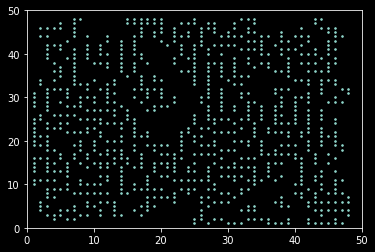

In [3]:
# Animation function
# An empty pyplot figure will be created, please ignore it
tb = ConwaysTestbed()
fig, scat = tb.initialize_testbed(n_rows=50, n_cols=50, density=0.1)

def animate(i, tb):
    tb.update_bed()
    x, y = tb.find_active_nodes()
    data = np.asarray([x, y]).T
    scat.set_offsets(data)
    return (scat,)

anim = animation.FuncAnimation(fig, animate, frames=200, interval=100, fargs=(tb,)) 
anim.save('conways.gif', writer='imagemagick') 